In [1]:
import time, importlib
import pylab as pl, numpy as np, glob, pdb
from numpy import log10 as log
import astropy
from astropy import units as un, constants as cons

In [7]:
simname = 'm12i'
z = 0.0016
#### change the following to location of npz file
fn = 'profiles_files/profiler_%s_md_7100_z%.4f.npz'%(simname,z)  
f = np.load(fn)

In [8]:
log_r2rvir_bins = np.arange(-3,0.5,.01)
rvir = f['rvir']
rs = 10.**((log_r2rvir_bins[1:]+log_r2rvir_bins[:-1])/2)*rvir
drs = np.pad((rs[2:]-rs[:-2])/2., 1, 'edge')

In [20]:
Mdot_highT  = -f['Mdot_hot_nodisc']
Mdot_lowT = -f['Mdot_cool_nodisc2']
Ms = np.array([f['massProfile%d'%iPartType] for iPartType in (0,1,2,4)]).sum(axis=0)
vc =((cons.G*un.Msun / un.kpc)**0.5).to('km/s').value * (Ms.cumsum() / rs)**0.5 
g = vc**2 / rs
Mdot_cool = f['rad_per_unit_mass_MW'] * f['massProfile0'] / drs / g
Mdot_cool *= (un.erg * un.s**-1 *un.g**-1 * un.Msun * (un.km/un.s)**-2).to('Msun/yr')

In [21]:
fig_width_full_pt = 513.11743  # Get this from LaTeX using \showthe\columnwidth
fig_width_half_pt = 245.26653
inches_per_pt = 1.0/72.27               # Convert pt to inch
fig_width_full = fig_width_full_pt*inches_per_pt  # width in inches
fig_width_half = fig_width_half_pt*inches_per_pt 

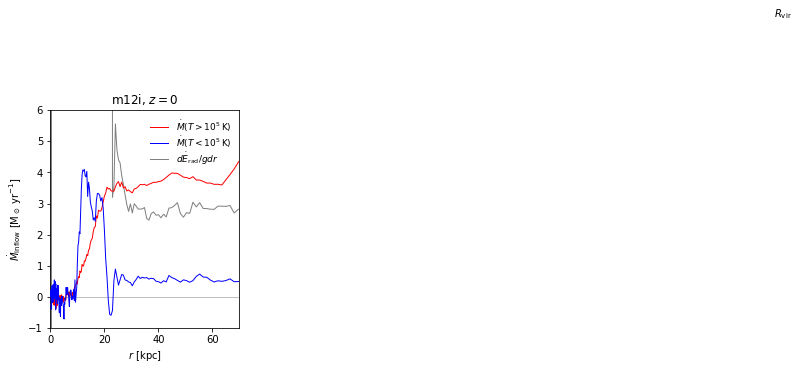

In [22]:
pl.figure(figsize=(fig_width_half,4))
ax=pl.subplot(111)
for i,Mdot in enumerate((Mdot_highT,Mdot_lowT,Mdot_cool)):
        label = (r'$\dot{M}(T>10^5\,{\rm K})$',r'$\dot{M}(T<10^5\,{\rm K})$',r'$d\dot{E}_{\rm rad}/gdr$')[i]
        pl.plot(rs,Mdot,c=('r','b','grey')[i],label=label,lw=1,zorder=(10,-10)[i==2])
# pl.axhline(sfrs[1],c='.5',lw=0.5)
# pl.text(5.2,sfrs[1]+0.25,r'${\rm SFR}$')
# pl.semilogx()
pl.axvline(rvir,c='.5',ls='-',lw=0.5)
pl.text(rvir,9,r'$R_{\rm vir}$')
pl.axhline(0,c='.5',ls='-',lw=0.5)
pl.xlim(0,70)
pl.ylim(-1,6)
pl.xlabel(r'$r\ [{\rm kpc}]$')
pl.ylabel(r'$\dot{M}_{\rm inflow}\ [{\rm M}_\odot\ {\rm yr}^{-1}]$')
pl.legend(ncol=1,fontsize=9,loc='upper right',labelspacing=0.1,frameon=False)
pl.title(r'%s, $z=%d$'%(simname,z))
pl.savefig('Mdot_%s.pdf'%simname,bbox_inches='tight')